## **Library**

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# from google.colab import drive
# drive.mount('/content/drive')

## **Load Data**

In [4]:
csv_path = 'Dataset PCD/Dataset.csv'
training_folder = 'Dataset PCD/Original Images/Original Images'
testing_folder = 'Dataset PCD/Faces/Faces'

df = pd.read_csv(csv_path)
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nUnique Labels:", df['label'].nunique())
print("\nLabel Distribution:")
print(df['label'].value_counts())

def load_images_from_folder(folder_path, label_df):
    images = []
    labels = []
    image_names = []

    for artist_folder in os.listdir(folder_path):
        artist_path = os.path.join(folder_path, artist_folder)

        if os.path.isdir(artist_path):
            for img_name in os.listdir(artist_path):
                img_path = os.path.join(artist_path, img_name)

                img = cv2.imread(img_path)
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(gray)
                    labels.append(artist_folder)
                    image_names.append(img_name)

    return images, labels, image_names

train_images, train_labels, train_names = load_images_from_folder(training_folder, df)
print(f"Total training images loaded: {len(train_images)}")
print(f"Unique artists: {len(set(train_labels))}")

# plt.figure(figsize=(12, 6))
# df['label'].value_counts().plot(kind='bar')
# plt.title('Distribusi Artis dalam Dataset')
# plt.xlabel('Nama Artis')
# plt.ylabel('Jumlah Gambar')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


Dataset Shape: (2562, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2562 non-null   object
 1   label   2562 non-null   object
dtypes: object(2)
memory usage: 40.2+ KB
None

First 5 rows:
                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan

Unique Labels: 31

Label Distribution:
label
Brad Pitt             120
Vijay Deverakonda     115
Robert Downey Jr      113
Hugh Jackman          112
Jessica Alba          108
Henry Cavill          106
Natalie Portman       105
Priyanka Chopra       102
Hrithik Roshan        101
Billie Eilish          98
Claire Holt            96
Alexandra Daddario     92
Andy Samberg         

## **EDA**

In [ ]:

print("\n\n2. ANALISIS DISTRIBUSI LABEL")
print("-"*40)
label_counts = df['label'].value_counts().sort_index()
unique_labels = df['label'].nunique()

print(f"✓ Jumlah kelas/individu unik: {unique_labels}")
print(f"✓ Total sampel per kelas:")
for label, count in label_counts.items():
    print(f"   - {label}: {count} gambar")

print(f"\nStatistik distribusi:")
print(f"   - Rata-rata sampel per kelas: {label_counts.mean():.2f}")
print(f"   - Median sampel per kelas: {label_counts.median():.2f}")
print(f"   - Std deviasi: {label_counts.std():.2f}")
print(f"   - Min sampel: {label_counts.min()}")
print(f"   - Max sampel: {label_counts.max()}")

print("\n\n3. VALIDASI KEBERADAAN FILE GAMBAR")
print("-"*40)
missing_images = []
existing_images = []
corrupted_images = []

for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])

    if not os.path.exists(image_path):
        missing_images.append((idx, row['id'], row['label']))
    else:
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                corrupted_images.append((idx, row['id'], row['label']))
            else:
                existing_images.append((idx, row['id'], row['label']))
        except:
            corrupted_images.append((idx, row['id'], row['label']))

print(f"✓ Gambar yang tersedia: {len(existing_images)}")
print(f"✗ Gambar yang hilang: {len(missing_images)}")
print(f"✗ Gambar yang corrupt: {len(corrupted_images)}")

if missing_images:
    print(f"\nContoh gambar yang hilang:")
    for i, (idx, img_id, label) in enumerate(missing_images[:5]):
        print(f"   - Index {idx}: {img_id} (Label: {label})")

print("\n\n4. ANALISIS RESOLUSI GAMBAR")
print("-"*40)
resolutions = []
file_sizes = []

for idx, img_id, label in existing_images:
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resolutions.append(img.shape)
    file_sizes.append(os.path.getsize(image_path))

if resolutions:
    unique_resolutions = list(set(resolutions))
    print(f"✓ Resolusi unik yang ditemukan: {len(unique_resolutions)}")

    resolution_counts = Counter(resolutions)
    print(f"✓ Distribusi resolusi:")
    for res, count in sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {res[1]}x{res[0]}: {count} gambar ({count/len(resolutions)*100:.1f}%)")

    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]

    print(f"\nStatistik resolusi:")
    print(f"   - Tinggi: min={min(heights)}, max={max(heights)}, rata-rata={np.mean(heights):.1f}")
    print(f"   - Lebar: min={min(widths)}, max={max(widths)}, rata-rata={np.mean(widths):.1f}")

# 5. ANALISIS KUALITAS GAMBAR
print("\n\n5. ANALISIS KUALITAS GAMBAR")
print("-"*40)
brightness_stats = []
contrast_stats = []
blur_stats = []

sample_size = min(100, len(existing_images)) 
print(f"Menganalisis kualitas dari {sample_size} gambar sample...")

for i in range(sample_size):
    idx, img_id, label = existing_images[i]
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    brightness = np.mean(img)
    brightness_stats.append(brightness)

    contrast = np.std(img)
    contrast_stats.append(contrast)

    blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
    blur_stats.append(blur_score)

if brightness_stats:
    print(f"✓ Statistik Kecerahan:")
    print(f"   - Rata-rata: {np.mean(brightness_stats):.1f}")
    print(f"   - Min: {np.min(brightness_stats):.1f}, Max: {np.max(brightness_stats):.1f}")

    print(f"✓ Statistik Kontras:")
    print(f"   - Rata-rata: {np.mean(contrast_stats):.1f}")
    print(f"   - Min: {np.min(contrast_stats):.1f}, Max: {np.max(contrast_stats):.1f}")

    print(f"✓ Statistik Blur (semakin tinggi = semakin tajam):")
    print(f"   - Rata-rata: {np.mean(blur_stats):.1f}")
    print(f"   - Min: {np.min(blur_stats):.1f}, Max: {np.max(blur_stats):.1f}")

    # Identifikasi gambar bermasalah
    very_dark = sum(1 for b in brightness_stats if b < 50)
    very_bright = sum(1 for b in brightness_stats if b > 200)
    low_contrast = sum(1 for c in contrast_stats if c < 20)
    very_blurry = sum(1 for bl in blur_stats if bl < 100)

    print(f"\n⚠️  Potensi masalah kualitas:")
    print(f"   - Gambar terlalu gelap (< 50): {very_dark}")
    print(f"   - Gambar terlalu terang (> 200): {very_bright}")
    print(f"   - Kontras rendah (< 20): {low_contrast}")
    print(f"   - Gambar blur (< 100): {very_blurry}")

print("\n\n6. ANALISIS KESEIMBANGAN KELAS")
print("-"*40)
class_proportions = df['label'].value_counts(normalize=True).sort_index()

print(f"✓ Proporsi setiap kelas:")
for label, prop in class_proportions.items():
    print(f"   - {label}: {prop:.3f} ({prop*100:.1f}%)")

max_samples = label_counts.max()
min_samples = label_counts.min()
imbalance_ratio = max_samples / min_samples

print(f"\n✓ Analisis keseimbangan:")
print(f"   - Rasio ketidakseimbangan: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print(f"   ⚠️  Dataset tidak seimbang - pertimbangkan teknik balancing")
else:
    print(f"   ✓ Dataset relatif seimbang")

print("\n\n7. MEMBUAT VISUALISASI")
print("-"*40)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
label_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title("Distribusi Jumlah Gambar per Individu", fontsize=12, fontweight='bold')
plt.xlabel("Label (Individu)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

if resolutions:
    plt.subplot(2, 2, 2)
    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]
    plt.scatter(widths, heights, alpha=0.6, c='coral')
    plt.title("Distribusi Resolusi Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Lebar (pixels)")
    plt.ylabel("Tinggi (pixels)")
    plt.grid(True, alpha=0.3)

if brightness_stats:
    plt.subplot(2, 2, 3)
    plt.hist(brightness_stats, bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.title("Distribusi Kecerahan Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Nilai Kecerahan")
    plt.ylabel("Frekuensi")
    plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 2, 4)
colors = plt.cm.Set3(np.linspace(0, 1, len(class_proportions)))
plt.pie(class_proportions.values, labels=class_proportions.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title("Proporsi Kelas", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n8. CONTOH GAMBAR DARI DATASET")
print("-"*40)

if existing_images:
    plt.figure(figsize=(15, 10))

    samples_per_class = {}
    for idx, img_id, label in existing_images:
        if label not in samples_per_class:
            samples_per_class[label] = []
        if len(samples_per_class[label]) < 3: 
            samples_per_class[label].append((img_id, idx))

    plot_idx = 1
    for label, samples in samples_per_class.items():
        for img_id, idx in samples:
            if plot_idx > 15: 
                break

            image_path = os.path.join(img_folder, img_id)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            plt.subplot(3, 5, plot_idx)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label: {label}\nSize: {img.shape}", fontsize=8)
            plt.axis('off')
            plot_idx += 1

        if plot_idx > 15:
            break

    plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## **Preprocessing and Data Preparation**

### **Face Detection dan Cropping**

In [6]:
def detect_and_crop_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        padding = int(0.1 * w)
        y1 = max(0, y - padding)
        y2 = min(image.shape[0], y + h + padding)
        x1 = max(0, x - padding)
        x2 = min(image.shape[1], x + w + padding)

        face_crop = image[y1:y2, x1:x2]
        return face_crop
    else:
        return image

print("Detecting and cropping faces...")
cropped_faces = []
valid_labels = []
valid_names = []

for i, (img, label, name) in enumerate(zip(train_images, train_labels, train_names)):
    face = detect_and_crop_face(img)
    if face is not None and face.size > 0:
        cropped_faces.append(face)
        valid_labels.append(label)
        valid_names.append(name)

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(train_images)} images")

print(f"Successfully cropped {len(cropped_faces)} faces")

Detecting and cropping faces...
Processed 100/2562 images
Processed 200/2562 images
Processed 300/2562 images
Processed 400/2562 images
Processed 500/2562 images
Processed 600/2562 images
Processed 700/2562 images
Processed 800/2562 images
Processed 900/2562 images
Processed 1000/2562 images
Processed 1100/2562 images
Processed 1200/2562 images
Processed 1300/2562 images
Processed 1400/2562 images
Processed 1500/2562 images
Processed 1600/2562 images
Processed 1700/2562 images
Processed 1800/2562 images
Processed 1900/2562 images
Processed 2000/2562 images
Processed 2100/2562 images
Processed 2200/2562 images
Processed 2300/2562 images
Processed 2400/2562 images
Processed 2500/2562 images
Successfully cropped 2562 faces


### **Data Augmented**

In [7]:
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)

        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)
        augmented_labels.append(label)

        bright = cv2.convertScaleAbs(img, alpha=1.2, beta=10)
        dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-10)
        augmented_images.append(bright)
        augmented_labels.append(label)
        augmented_images.append(dark)
        augmented_labels.append(label)

    return augmented_images, augmented_labels

print("Augmenting data...")
augmented_faces, augmented_labels = augment_data(cropped_faces, valid_labels)
print(f"Augmented data size: {len(augmented_faces)}")

Augmenting data...
Augmented data size: 10248


### **Resize Images**

Resized faces shape: (10248, 128, 128)


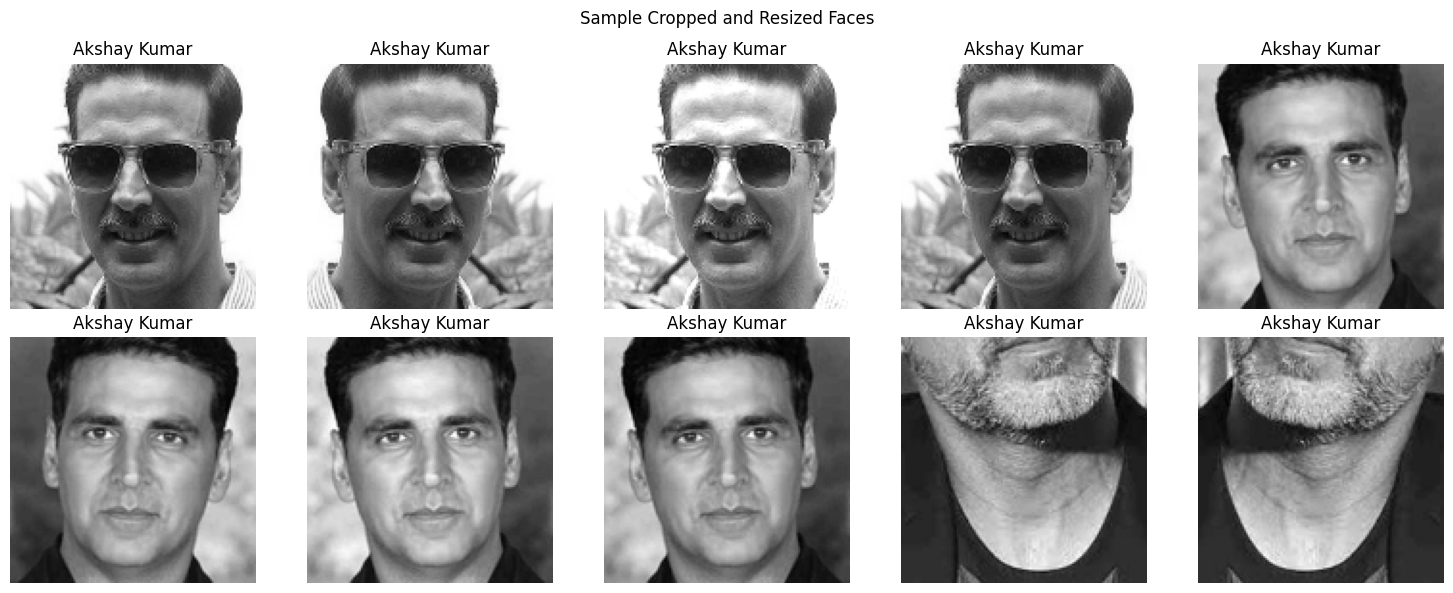

In [8]:
def resize_images(images, size=(128, 128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, size)
        resized_images.append(resized)
    return np.array(resized_images)

resized_faces = resize_images(augmented_faces)
print(f"Resized faces shape: {resized_faces.shape}")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(resized_faces):
        ax.imshow(resized_faces[i], cmap='gray')
        ax.set_title(valid_labels[i])
        ax.axis('off')
plt.suptitle('Sample Cropped and Resized Faces')
plt.tight_layout()
plt.show()


### **Local Binary Pattern (LBP) Implementation**

In [9]:
def calculate_lbp(image, radius=1, n_points=8):
    rows, cols = image.shape
    lbp_image = np.zeros_like(image)

    for i in range(radius, rows - radius):
        for j in range(radius, cols - radius):
            center = image[i, j]
            binary_code = 0

            for p in range(n_points):
                theta = 2 * np.pi * p / n_points
                neighbor_x = i + radius * np.cos(theta)
                neighbor_y = j + radius * np.sin(theta)

                x1, y1 = int(neighbor_x), int(neighbor_y)
                x2, y2 = x1 + 1, y1 + 1

                x1 = max(0, min(x1, rows - 1))
                x2 = max(0, min(x2, rows - 1))
                y1 = max(0, min(y1, cols - 1))
                y2 = max(0, min(y2, cols - 1))

                fx = neighbor_x - x1
                fy = neighbor_y - y1

                neighbor_value = (1 - fx) * (1 - fy) * image[x1, y1] + \
                                fx * (1 - fy) * image[x2, y1] + \
                                (1 - fx) * fy * image[x1, y2] + \
                                fx * fy * image[x2, y2]

                if neighbor_value >= center:
                    binary_code |= (1 << p)

            lbp_image[i, j] = binary_code

    return lbp_image

### **Local Binary Pattern Histogram (LBPH) Implementation**

In [11]:
def calculate_lbph(image, radius=1, n_points=8, grid_x=8, grid_y=8):
    lbp_image = calculate_lbp(image, radius, n_points)

    height, width = lbp_image.shape
    grid_height = height // grid_y
    grid_width = width // grid_x

    histograms = []

    for i in range(grid_y):
        for j in range(grid_x):
            y1 = i * grid_height
            y2 = (i + 1) * grid_height if i < grid_y - 1 else height
            x1 = j * grid_width
            x2 = (j + 1) * grid_width if j < grid_x - 1 else width

            grid = lbp_image[y1:y2, x1:x2]

            hist, _ = np.histogram(grid, bins=2**n_points, range=(0, 2**n_points))
            histograms.append(hist)

    feature_vector = np.concatenate(histograms)

    feature_vector = feature_vector / (feature_vector.sum() + 1e-7)

    return feature_vector

print("Extracting LBPH features...")
lbph_features = []
for i, face in enumerate(resized_faces):
    features = calculate_lbph(face, radius=1, n_points=8, grid_x=8, grid_y=8)
    lbph_features.append(features)

    if (i + 1) % 50 == 0:
        print(f"Extracted features for {i + 1}/{len(resized_faces)} images")

lbph_features = np.array(lbph_features)
print(f"LBPH features shape: {lbph_features.shape}")

Extracting LBPH features...
Extracted features for 50/10248 images
Extracted features for 100/10248 images
Extracted features for 150/10248 images
Extracted features for 200/10248 images
Extracted features for 250/10248 images
Extracted features for 300/10248 images
Extracted features for 350/10248 images
Extracted features for 400/10248 images
Extracted features for 450/10248 images
Extracted features for 500/10248 images
Extracted features for 550/10248 images
Extracted features for 600/10248 images
Extracted features for 650/10248 images
Extracted features for 700/10248 images
Extracted features for 750/10248 images
Extracted features for 800/10248 images
Extracted features for 850/10248 images
Extracted features for 900/10248 images
Extracted features for 950/10248 images
Extracted features for 1000/10248 images
Extracted features for 1050/10248 images
Extracted features for 1100/10248 images
Extracted features for 1150/10248 images
Extracted features for 1200/10248 images
Extracte

### **Label Encoding**

In [12]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(augmented_labels)  # Ganti dari valid_labels
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")
print(f"Number of encoded labels: {len(encoded_labels)}")  # Tambahkan ini untuk verifikasi

Number of classes: 31
Classes: ['Akshay Kumar' 'Alexandra Daddario' 'Alia Bhatt' 'Amitabh Bachchan'
 'Andy Samberg' 'Anushka Sharma' 'Billie Eilish' 'Brad Pitt'
 'Camila Cabello' 'Charlize Theron' 'Claire Holt' 'Courtney Cox'
 'Dwayne Johnson' 'Elizabeth Olsen' 'Ellen Degeneres' 'Henry Cavill'
 'Hrithik Roshan' 'Hugh Jackman' 'Jessica Alba' 'Kashyap' 'Lisa Kudrow'
 'Margot Robbie' 'Marmik' 'Natalie Portman' 'Priyanka Chopra'
 'Robert Downey Jr' 'Roger Federer' 'Tom Cruise' 'Vijay Deverakonda'
 'Virat Kohli' 'Zac Efron']
Number of encoded labels: 10248


### **Data Split for Training and Validation**

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    lbph_features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (8198, 16384)
Validation set size: (2050, 16384)


## **Features Selection Using PCA**

Original features: 16384
PCA features: 490
Variance explained: 90.02%


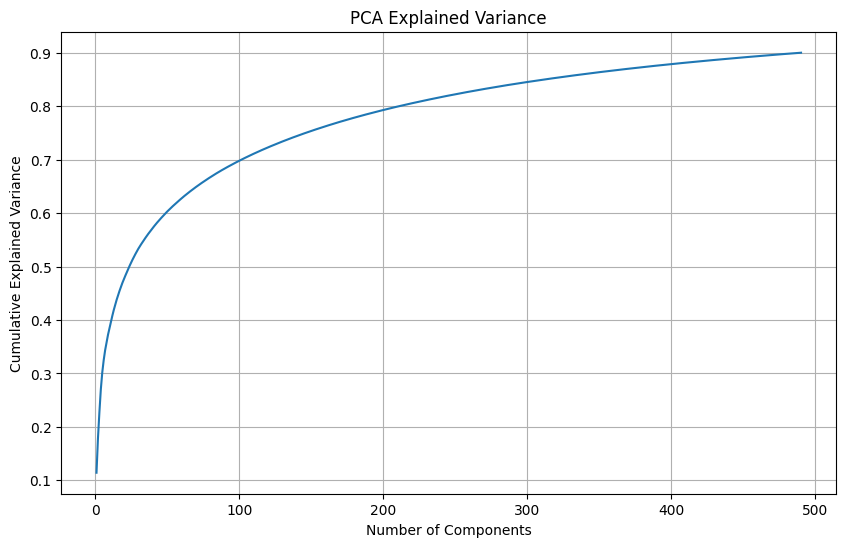

In [14]:
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print(f"Original features: {X_train.shape[1]}")
print(f"PCA features: {X_train_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(10, 6))
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## **Training Set**

### **Support Vector Classification**

In [15]:
print("Training SVC model...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=901)
svm_model.fit(X_train_pca, y_train)
svm_pred = svm_model.predict(X_val_pca)
svm_accuracy = accuracy_score(y_val, svm_pred)
print(f"SVC Accuracy: {svm_accuracy:.4f}")

Training SVC model...
SVC Accuracy: 0.8327


### **Random Forest**

In [16]:
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=901, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)
rf_pred = rf_model.predict(X_val_pca)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Training Random Forest model...
Random Forest Accuracy: 0.7337


## **Validation Set**

### **RF Validation**


Best Model: RF with accuracy 0.7337

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.95      0.53      0.68        40
Alexandra Daddario       0.75      0.80      0.77        74
        Alia Bhatt       0.85      0.73      0.79        63
  Amitabh Bachchan       0.81      0.78      0.79        59
      Andy Samberg       0.76      0.72      0.74        74
    Anushka Sharma       0.88      0.56      0.68        54
     Billie Eilish       0.71      0.73      0.72        78
         Brad Pitt       0.53      0.80      0.64        96
    Camila Cabello       0.76      0.79      0.77        70
   Charlize Theron       0.88      0.68      0.76        62
       Claire Holt       0.76      0.78      0.77        77
      Courtney Cox       0.80      0.83      0.82        64
    Dwayne Johnson       1.00      0.71      0.83        49
   Elizabeth Olsen       0.88      0.65      0.75        57
   Ellen Degeneres       0.88      0.7

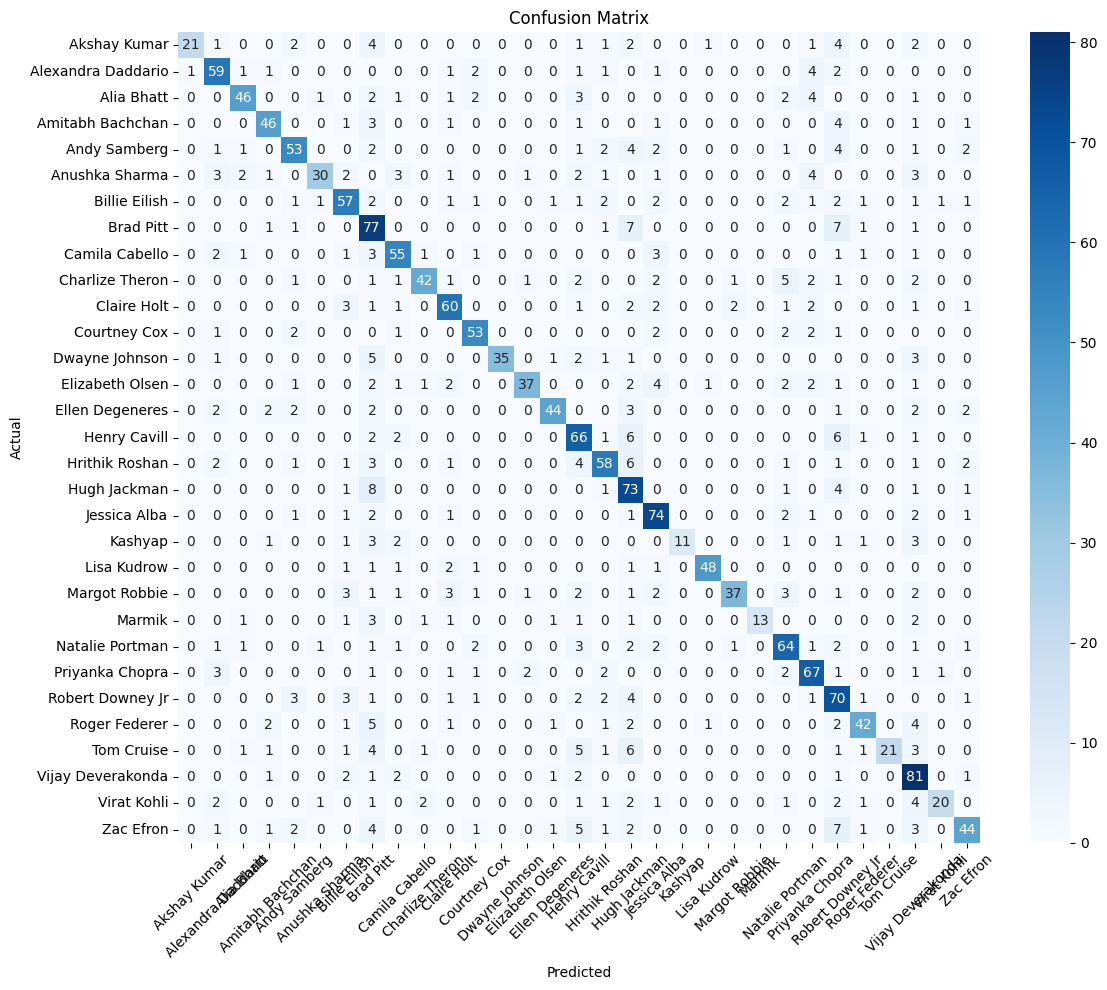

In [18]:
best_model = rf_model
best_pred = rf_pred
best_accuracy = rf_accuracy

print(f"\nBest Model: RF with accuracy {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **SVC Validation**


Best Model: SVM with accuracy 0.8327

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.72      0.70      0.71        40
Alexandra Daddario       0.86      0.88      0.87        74
        Alia Bhatt       0.75      0.79      0.77        63
  Amitabh Bachchan       0.94      0.83      0.88        59
      Andy Samberg       0.85      0.81      0.83        74
    Anushka Sharma       0.60      0.69      0.64        54
     Billie Eilish       0.72      0.81      0.76        78
         Brad Pitt       0.84      0.83      0.84        96
    Camila Cabello       0.84      0.84      0.84        70
   Charlize Theron       0.91      0.84      0.87        62
       Claire Holt       0.78      0.83      0.81        77
      Courtney Cox       0.95      0.94      0.94        64
    Dwayne Johnson       0.98      0.90      0.94        49
   Elizabeth Olsen       0.91      0.88      0.89        57
   Ellen Degeneres       0.89      0.

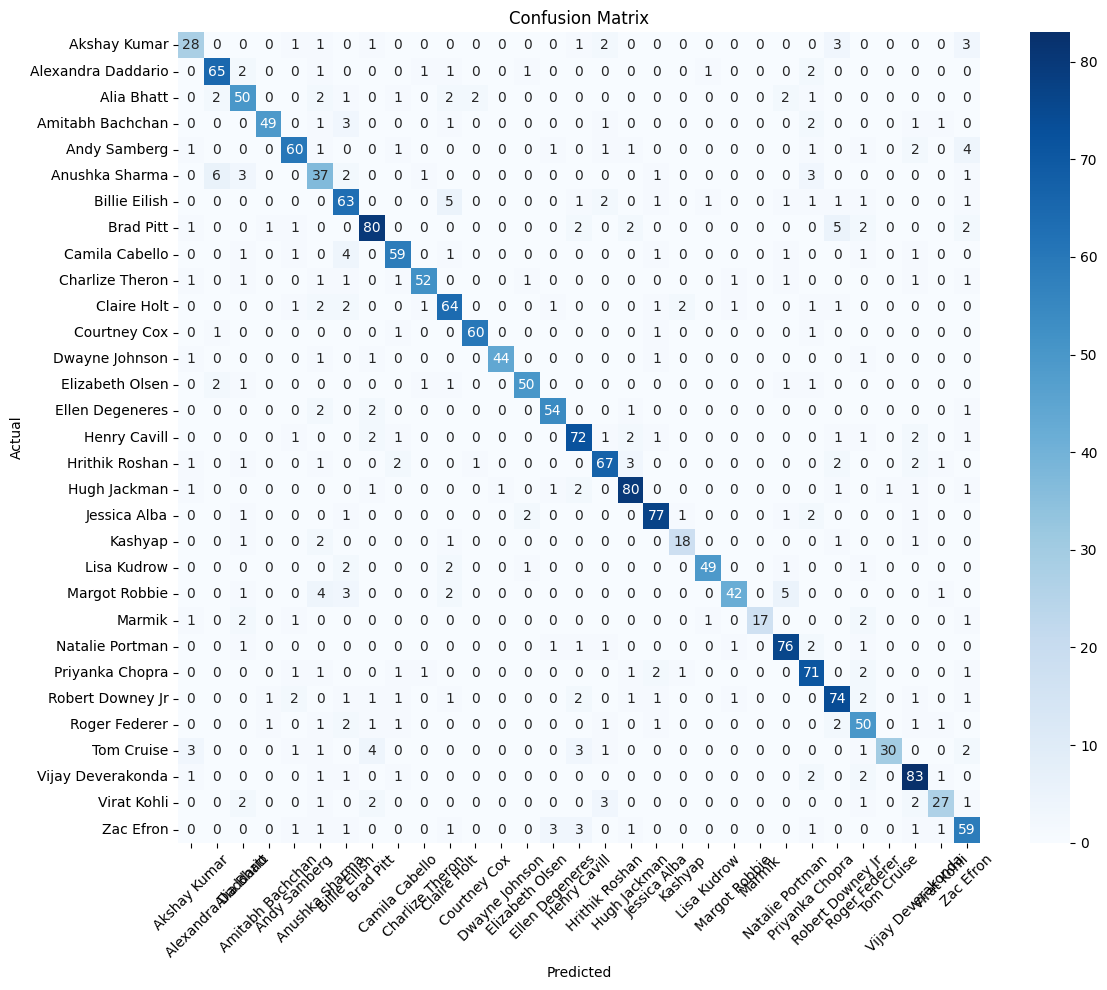

In [20]:
best_model = svm_model
best_pred = svm_pred
best_accuracy = svm_accuracy

print(f"\nBest Model: SVM with accuracy {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Testing Set**

### **Load Testing Data**

In [ ]:
def load_test_images(test_folder):
    test_images = []
    test_names = []

    for img_name in os.listdir(test_folder):
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            test_images.append(gray)
            test_names.append(img_name)

    return test_images, test_names

print("Loading test images...")
test_images, test_names = load_test_images(testing_folder)
print(f"Loaded {len(test_images)} test images")

### **Data Preparation for Testing Set**

In [ ]:
test_cropped = []
valid_test_names = []

for img, name in zip(test_images, test_names):
    face = detect_and_crop_face(img)
    if face is not None and face.size > 0:
        test_cropped.append(face)
        valid_test_names.append(name)

test_resized = resize_images(test_cropped)

print("Extracting features from test images...")
test_features = []
for face in test_resized:
    features = calculate_lbph(face, radius=1, n_points=8, grid_x=8, grid_y=8)
    test_features.append(features)

test_features = np.array(test_features)

test_features_pca = pca.transform(test_features)

### **Predict Test Images**

In [ ]:
test_predictions = best_model.predict(test_features_pca)
test_pred_labels = label_encoder.inverse_transform(test_predictions)

results_df = pd.DataFrame({
    'image_name': valid_test_names,
    'predicted_artist': test_pred_labels
})

print("\nTest Results:")
print(results_df.head(10))

results_df.to_csv('test_predictions.csv', index=False)
print("\nPredictions saved to 'test_predictions.csv'")

### **Visualize Test Predictions**

In [ ]:
n_samples = min(10, len(test_resized))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < n_samples:
        ax.imshow(test_resized[i], cmap='gray')
        ax.set_title(f"Predicted: {test_pred_labels[i]}")
        ax.axis('off')

plt.suptitle('Sample Test Predictions')
plt.tight_layout()
plt.show()


In [ ]:
# # Cell 20: Save Final Model
# import pickle

# # Save the best model
# with open('face_recognition_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

# # Save the PCA transformer
# with open('pca_transformer.pkl', 'wb') as f:
#     pickle.dump(pca, f)

# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# print("Models saved successfully!")

## **Performance Metric Summary**

In [ ]:
print("\n=== PERFORMANCE SUMMARY ===")
print(f"Total Images Processed: {len(resized_faces)}")
print(f"Number of Classes: {len(label_encoder.classes_)}")
print(f"Feature Dimension (Original): {lbph_features.shape[1]}")
print(f"Feature Dimension (After PCA): {X_train_pca.shape[1]}")
print(f"\nModel Accuracies:")
print(f"- SVM: {svm_accuracy:.4f}")
print(f"- Random Forest: {rf_accuracy:.4f}")
print(f"\nBest Model: {'Ensemble' if ensemble_accuracy > best_accuracy else 'SVM'}")
print(f"Best Accuracy: {max(ensemble_accuracy, best_accuracy):.4f}")


=== PERFORMANCE SUMMARY ===
Total Images Processed: 10248
Number of Classes: 31
Feature Dimension (Original): 16384
Feature Dimension (After PCA): 490

Model Accuracies:
- SVM: 0.8327
- Random Forest: 0.7337
- KNN: 0.4956


NameError: name 'ensemble_accuracy' is not defined

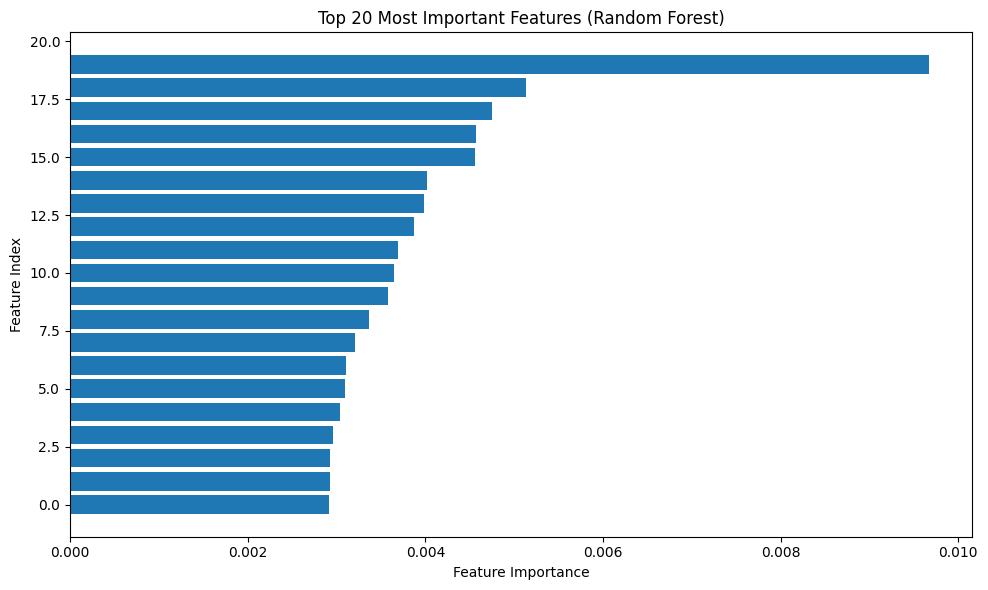

In [ ]:
feature_importances = rf_model.feature_importances_

top_features_idx = np.argsort(feature_importances)[-20:]
top_features_importance = feature_importances[top_features_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_idx)), top_features_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()